##### Author: Mukeba Mbunda Eliezer


## Case Study: Author Identification Analysis

This report provides a comprehensive walkthrough of an author identification analysis. The primary aim of this study is to develop a **Long Short-Term Memory (LSTM)** model capable of distinguishing or predicting an author based on their unique writing style.  
The goal is to create a system that can analyze an individual’s writing and infer the most likely author. Such a system has significant practical applications: accurately identifying an author based on stylistic markers is crucial in areas such as **plagiarism detection**, **forensic linguistics**, and the **analysis of historical manuscripts** (Abbasi & Chen, 2009).  

This notebook contains both the analysis and the code used to build and evaluate the model.


# Table of Contents
1. [Justification of the dataset ](#Justification-of-the-dataset)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
3. [Feature engineering ](#Featur-engineeringg)
4. [Train the model](#Train-the-model)
5. [Evaluate the  model](#Evaluate-the--model)
6. [Retrain the  model](#Retrain-the-model)
7. [Evaluate the  retrained model](#Evaluate-the-retrained-model)
6. [References](#References)

# Justification of the Dataset

The dataset used for this analysis was obtained from Kaggle, a platform that provides secondary datasets for academic purposes. Originally, Kaggle provided two versions of the dataset: a labeled corpus and an unlabeled corpus. For this analysis, we downloaded the labeled dataset, which was used in the Spooky Author Identification competition.  

**Original dataset link:** [Kaggle - Identify the Author](https://www.kaggle.com/datasets/lteodor/identify-the-author?select=labeled_sentence_corpus.csv)  
**Competition dataset link:** [Spooky Author Identification](https://www.kaggle.com/competitions/spooky-author-identification/data)  

The dataset contains texts from works of fiction by Edgar Allan Poe (EAP), H.P. Lovecraft (HPL), and Mary Shelley (MWS). The texts were collected from open-source repositories such as Project Gutenberg and the Internet Archive, and then segmented into sentences using the NLTK sentence tokenizer.  

While the original dataset included over 50,000 individual sentences, the version used in this analysis (and in the competition) contains 19,579 records. This dataset provides a suitable foundation for building models to identify authors based on their unique writing styles.  

This dataset was particularly suitable for the author identification task with LSTM models for several reasons:  

1. **Clear Data Structure**  

   The dataset contains two main columns:  

   - `id`: Represents the unique identifier for each record  
   - `Text`: Representing the author’s writing  
   - `Author`: Identifying the corresponding author  

   This structure ensures that the dataset can be directly used for classification tasks without additional restructuring. The dataset provided labeled sentences paired with their corresponding authors. This structure allowed the model to learn stylistic patterns by mapping text to its author (Savoy, 2020).  

2. **High Volume of Data**  

   With 19,579 sentences, the dataset offers sufficient examples for an LSTM to capture long-term dependencies in writing style. Large datasets are critical for deep learning models, as they provide the diversity and volume needed to avoid overfitting and improve generalization (Google Cloud, [s.a.]).  

3. **Sequential Nature of the Data**  

   LSTMs are designed to process sequential data such as text, where words follow an order and dependencies span across different time steps. Since the dataset consists of continuous sentences, it matches the requirements of sequence models. As AWS (s.a.) notes, recurrent neural networks like LSTM are most effective when trained on sequential data with complex semantic and syntactic structures.  

4. **Cleaned and Structured Text**  

   The data has been segmented into individual sentences using the NLTK sentence tokenizer. This preprocessing step improves model performance by providing clean, structured input sequences that LSTMs can effectively process, reducing noise and inconsistencies in the training phase (Lehau, 2025).  

5. **Relevance for Stylistic Learning**  

   The dataset is drawn from authors with distinctive writing styles. This diversity enhances the ability of the model to learn stylistic differences, which is crucial for the authorship attribution task (Savoy, 2020).  

## Analysis Plan

| **Step**                      | **Description**                                                                                                                                           |
|-------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|
| **1. Exploratory Data Analysis (EDA)** | - Import libraries, create Spark session, and load data <br> - Data cleaning: remove duplicate rows, handle null values, eliminate extra whitespace and non-printable characters <br> - Filter data for valid authors <br> - Visualization: bar plots, pie charts, histograms, box plots, and heatmaps |
| **2. Feature Engineering** | - Find maximum sequence length <br> - Prepare the data: preprocessing,lemmatization,  tokenization, padding, and encoding <br> - Split the data into training and testing sets |
| **3. Train the model** | - Prepare hyperparameters <br> - Build model using Sequential: Embedding layer, LSTM layer, Dense layer, Dropout layer, output Dense layer <br> - Compile the model <br> - Train the model on training data |
| **4. Evaluate the model** | - Evaluate performance using: <br> • Loss <br> • Accuracy <br> • Classification report (Precision, Recall, F1-score) <br> • Confusion matrix <br> • Plot training/validation loss and accuracy curves |
| **5. Retrain the model** | - Prepare hyperparameters <br> - Build model using Sequential: Embedding layer, **Bidirectional LSTM**, Dense layer, Dropout layer, output Dense layer <br> - Add callbacks: EarlyStopping, ReduceLROnPlateau <br> - Compile and train the model |
| **6. Evaluate the retrained model** | - Same evaluation steps as the trained model: <br> • Loss <br> • Accuracy <br> • Classification report (Precision, Recall, F1-score) <br> • Confusion matrix <br> • Plot training/validation loss and accuracy curves |
| **7. Report** | - Summarize results, explain improvements, and highlight findings <br> - Generate a PDF report for documentation and presentation |
| **8. References** | - List all references|

## Exploratory Data Analysis (EDA)

In this section, we perform the analysis as follows:

- Import libraries, create Spark session, and load data  
- Data cleaning: remove duplicate rows, handle null values, eliminate extra whitespace and non-printable characters  
- Filter data for valid authors  
- Visualization: bar plots, pie charts, histograms, box plots, and heatmaps

### 1. Import Libraries and Create Spark Session

We begin this analysis by importing the relevant libraries needed for the project. Next, we create a Spark session named `authorIdentification` and load the dataset downloaded from Kaggle. We then display the first five rows to get an overview of the dataset.

In [ ]:
# Importing libraries for data processing, visualization, and modeling

# Spark for distributed data processing
from pyspark.sql import SparkSession # Create Spark session
from pyspark.sql.functions import col, udf, from_json, length, lower, when, count, regexp_replace, explode, split, avg # Useful Spark SQL functions
from collections import Counter # Counter for counting elements
# Pandas and Numpy for data manipulation
import pandas as pd # DataFrames and data analysis
import numpy as np # Numerical operations
# Matplotlib and Seaborn for visualization
import matplotlib.pyplot as plt # Plotting graphs
import seaborn as sns # Statistical data visualization
# Scikit-learn for preprocessing and metrics
from sklearn.preprocessing import LabelEncoder # Encode categorical labels as integers
from sklearn.model_selection import train_test_split # Split data into train and test sets
from sklearn.utils.class_weight import compute_class_weight # Compute class weights for imbalanced data
from sklearn.metrics import confusion_matrix, classification_report # Model evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score
# NLTK for text preprocessing
import nltk # Natural Language Toolkit
from nltk.corpus import stopwords # List of stopwords
from nltk.stem import WordNetLemmatizer # Lemmatization of words
# TensorFlow Keras for deep learning
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore # Convert text to sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore # Pad sequences to same length
from tensorflow.keras.models import Sequential # type: ignore # Sequential model architecture
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional  # type: ignore # Neural network layers
from tensorflow.keras.optimizers import Adam  # type: ignore # Optimizer for training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau   # type: ignore # Training callbacks
# Regular expressions for text cleaning
import re # Regular expressions
# OS for environment configuration
import os # Operating system functions
os.environ["PYSPARK_PYTHON"] = "python" # Set PySpark Python interpreter
os.environ["PYSPARK_DRIVER_PYTHON"] = "python" # Set PySpark driver Python interpreter

In [18]:
# Creating a spark session and loading the dataset

# Create Spark session
spark = SparkSession.builder.appName("AuthorIdentification").getOrCreate() 

# Load dataset
df = spark.read.csv("train.csv", header=True, inferSchema=True)

# Print dimensions
print((df.count(), len(df.columns)))

# Show first 5 rows
df.show(5, truncate=900) 

(19579, 3)
+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|     id|                                                                                                                                                                                                                                   text|author|
+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|id26305|This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.| 

### 2. Data Cleaning

After loading the dataset, it is essential to clean the data to ensure its quality and consistency. This process involves removing duplicate rows, handling any missing or null values, and eliminating extra whitespace or non-printable characters. Proper data cleaning helps prevent errors during analysis and ensures that the model receives accurate and well-structured input for training.

In [19]:
# Function to clean the data 
def deepclean(df):
    """
    Function to clean the dataframe by:
    - Dropping duplicates
    - Dropping rows with null values
    - Removing extra whitespaces
    - Removing non-printable characters
    """
    # Initial number of rows
    initial_count = df.count()
    # Drop duplicates
    df_clean = df.dropDuplicates()
    # Drop rows with null values
    df_clean = df_clean.dropna(subset=["text", "author"])
    # # Remove exra whitespaces
    df_clean = df_clean.withColumn("text", regexp_replace(col("text"), "\s+", " "))
    # # Remove non-printable characters
    df_clean = df_clean.withColumn("text", regexp_replace(col("text"), "[^\x20-\x7E]", ""))
    # Final number of rows
    final_count = df_clean.count()

    return df_clean, initial_count, final_count

In [20]:
# Clean the dataframe

df_clean, initial_count, final_count = deepclean(df)
print(f"Initial number of rows: {initial_count}")
print(f"Final number of rows: {final_count}")

# Show first 5 rows of the cleaned dataframe
df_clean.show(5, truncate=900)

Initial number of rows: 19579
Final number of rows: 19579
+-------+----------------------------------------------------------------------------------------------------------------------+----------------+
|     id|                                                                                                                  text|          author|
+-------+----------------------------------------------------------------------------------------------------------------------+----------------+
|id19806|                                                                         """But that Kidd's accumulations were immense| is well known."|
|id21409|         The bandage lay heavily about the mouth but then might it not be the mouth of the breathing Lady of Tremaine?|             EAP|
|id22107|                                           We expelled the bodies through the double hatches and were alone in the U .|             HPL|
|id23537|                              Of the various tales that o

### 3. Filter Data

After cleaning the dataset, we filter the data to include only the three authors of interest: **Edgar Allan Poe (EAP), H.P. Lovecraft (HPL), and Mary Shelley (MWS)**. 
This ensures that the analysis focuses solely on these authors and allows the model to learn and predict their unique writing styles accurately.

In [21]:
#  Filter for valid authors
authors = ["HPL","EAP","MWS"]
df_filter = df_clean.filter(col("author").isin(authors))

print(f"Final number of rows after cleanning : {final_count}")
print("Final number of rows after flitering : ", df_filter.count())

# group by author and count number of sentences per author
author_counts = df_filter.groupBy("author").count().orderBy(col("count").desc())
author_counts.show()


Final number of rows after cleanning : 19579
Final number of rows after flitering :  18047
+------+-----+
|author|count|
+------+-----+
|   EAP| 7044|
|   MWS| 5552|
|   HPL| 5451|
+------+-----+



After filtering the dataset, we found the number of records for each author as follows:

- **EAP (Edgar Allan Poe):** 7,044 records  
- **MWS (Mary Shelley):** 5,552 records  
- **HPL (H.P. Lovecraft):** 5,441 records  

Next, we will check for missing and duplicate values, and print the dataset schema to inspect its structure.

In [22]:
# Check for missing values

print("Number of missing values per column:")
df_filter.select([count(when(col(c).isNull(), c)).alias(c) for c in df_filter.columns]).show()

# check for duplicates
print("Number of duplicate rows: ", df_filter.count() - df_filter.dropDuplicates().count())

# Print schema
df_filter.printSchema()

Number of missing values per column:
+---+----+------+
| id|text|author|
+---+----+------+
|  0|   0|     0|
+---+----+------+

Number of duplicate rows:  0
root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)



After checking, we found no missing or duplicate records. The schema shows that all the data in the dataset are of type **string**.  

### 4. Visualization

Next, we visualize the distribution of the data using the following graphs:

- Bar plots  
- Pie charts  
- Histograms  
- Box plots  
- Heatmaps

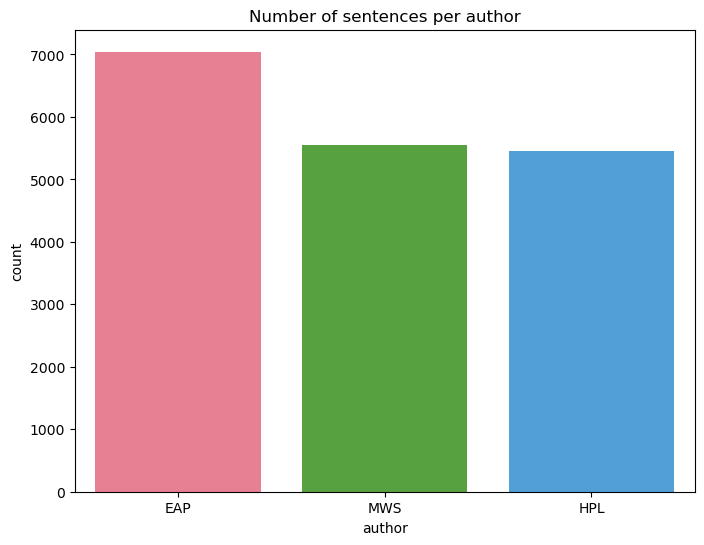

In [23]:
# Plot frequency of authors

# Convert to Pandas dataframe for plotting
author_counts_pandas = author_counts.toPandas() 

# Set figure size
plt.figure(figsize=(8,6)) 

# Plot barplot
sns.barplot(x="author", hue="author", y="count", data=author_counts_pandas, palette="husl", legend=False) 

# Set title
plt.title("Number of sentences per author")

# Display the plot
plt.show() 

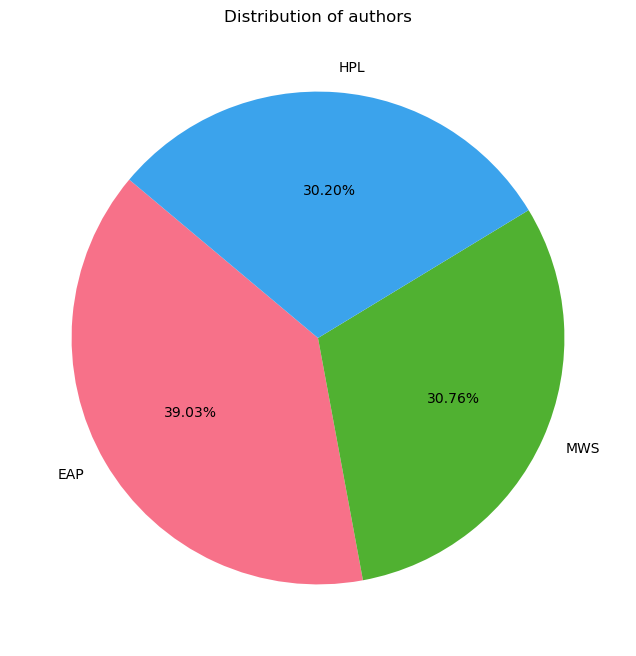

In [24]:
# Plot the distribution of authors using pie chart

# Set figure size
plt.figure(figsize=(8,8))

# set axes
ax = plt.subplot(1,1,1)

# Plot pie chart
plt.pie(author_counts_pandas['count'], labels=author_counts_pandas['author'], autopct='%1.2f%%', startangle=140, colors=sns.color_palette("husl", len(author_counts_pandas)))

# Display the plot
plt.title("Distribution of authors")
plt.show()



The bar plot and pie chart show that it is evident **H.P. Lovecraft (HPL)** has the highest number of sentences, followed by **Edgar Allan Poe (EAP)**, and then **Mary Shelley (MWS)**. This suggests that HPL’s works are more extensively represented in the dataset compared to the other authors. The visualizations highlight the relative representation of the three authors in the dataset.

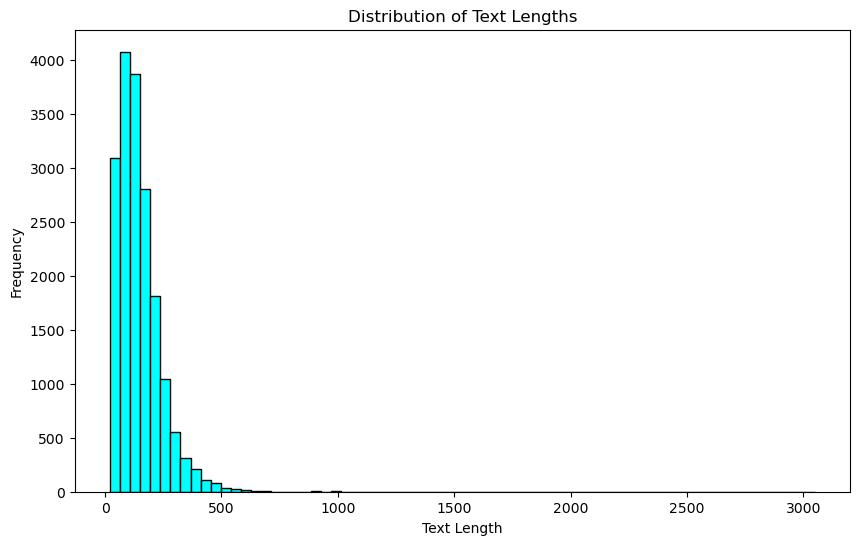

In [25]:
# histogram of text length

#  New column with the length of each text
df_length = df_filter.withColumn("text_length", length(col("text")))

# Convert to Pandas dataframe for plotting
df_length_pandas = df_length.select("text_length").toPandas()

# Set figure size
plt.figure(figsize=(10,6))

# Plot histogram
plt.hist(df_length_pandas['text_length'], bins=70, color='cyan', edgecolor='black')

# Set title and labels
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")

# Display the plot
plt.show()

The figure above shows the distribution of text lengths in the dataset. It can be observed that texts with an average length of **314 words** are the most frequent. (This will be calculated later in the Feature Engineering section.)

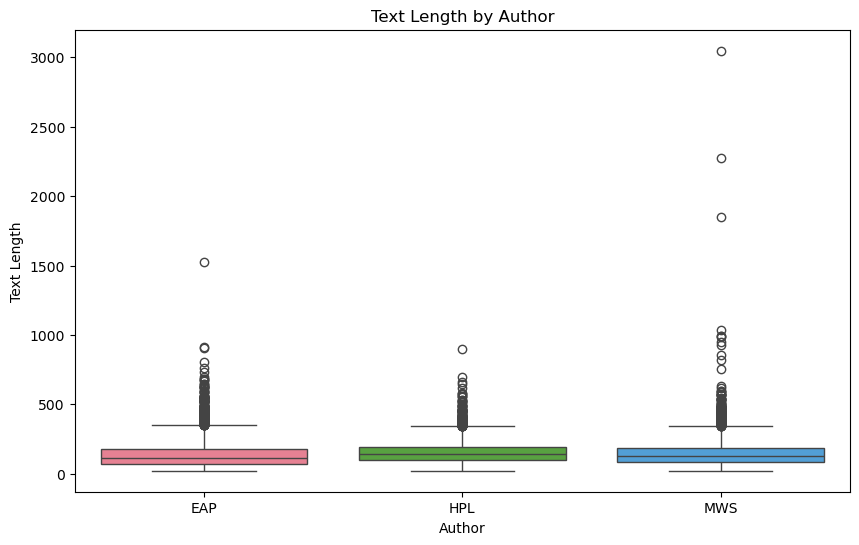

In [26]:
# Box plot of text length by author

# Convert to Pandas dataframe for plotting
df_length_author_pandas = df_length.select("author", "text_length").toPandas()

# Set figure size
plt.figure(figsize=(10,6))

# Plot boxplot
sns.boxplot(x="author", hue="author", y="text_length", data=df_length_author_pandas, palette="husl", legend=False)

# Set title and labels
plt.title("Text Length by Author")
plt.xlabel("Author")
plt.ylabel("Text Length")

# Display the plot
plt.show()

The figure above illustrates the presence of outliers for each author. Texts with lengths close to or exceeding **500 words** are considered outliers, which may introduce noise into the data

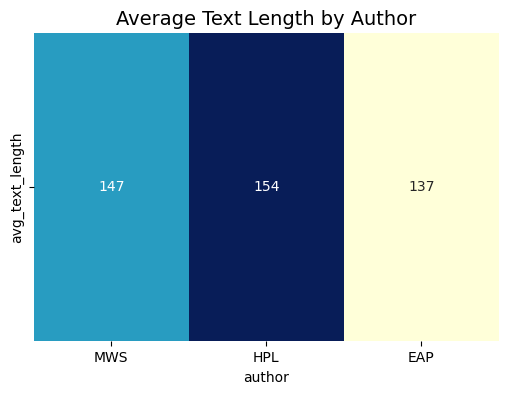

In [27]:
# Heatmap of average text length by author

# Group by author and calculate average text length
avg_length = df_length.groupBy("author").agg(avg("text_length").alias("avg_text_length"))

# Convert to Pandas dataframe for plotting
avg_length_pandas = avg_length.toPandas()

# Convert average text length to integer to avoid scientific notation
avg_length_pandas['avg_text_length'] = avg_length_pandas['avg_text_length'].apply(lambda x: int(x))

# Set figure size
plt.figure(figsize=(6,4))

# Set heatmap with integers formatted properly
sns.heatmap(avg_length_pandas.set_index('author').T, 
            annot=True, fmt=".0f", cmap="YlGnBu", cbar=False)

# Set title
plt.title("Average Text Length by Author", fontsize=14)

# Display the plot
plt.show()

We can see that **H.P. Lovecraft (HPL)** has the highest average text length of **154 words**, followed by **Mary Shelley (MWS)** with **147 words**, and **Edgar Allan Poe (EAP)** with **137 words**.

## Feature Engineering

In this section, we perform the following steps:

- Find the maximum sequence length  
- Prepare the data: preprocessing, lematization, tokenization, padding, and encoding  
- Split the data into training and testing sets

We begin by calculating the maximum sequence length (`maxlen`), as it will be useful for preparing the input data for the model.

In [28]:
# Find maxlen that covers 95% of the texts
maxlen_ = int(np.percentile(df_length_pandas, 95))
print("Recommended maxlen:", maxlen_)

Recommended maxlen: 314


Following this, we will convert all text to lowercase, remove special characters, eliminate stopwords, and apply lemmatization to reduce words to their root form. Next, we will tokenize the data to transform the text into sequences of integers representing words. To ensure consistent input length for the model, we will apply padding to the sequences, allowing shorter texts to match the maximum sequence length.

In [30]:
# NLTK downloads
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Functions for text prprocessing
def preprocess_text(text):
    """Lowercase, remove special characters, stopwords, lemmatize"""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # keep only letters and spaces
    words = text.split()
    words = [w for w in words if w not in stop_words]  # remove stopwords
    words = [lemmatizer.lemmatize(w) for w in words]  # lemmatize
    return " ".join(words)

# Function to tokenize texts
def tokenize_texts(texts, num_words=None):
    """Fit tokenizer on texts and convert to sequences"""
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    vocab_size = len(tokenizer.word_index) + 1
    return sequences, tokenizer, vocab_size

# Function to pad sequences
def pad_text_sequences(sequences, maxlen=310):
    """Pad sequences to the same length"""
    padded = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
    return padded

# Function to encode labels
def encode_labels(labels):
    """Encode class labels into integers"""
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    return encoded_labels, encoder

# Function to prepare data for modeling
def prepare_data(df, text_col="text", label_col="author", maxlen=314, num_words=None, test_size=0.2, random_state=42):
    # Preprocess text
    df[text_col] = df[text_col].apply(preprocess_text)
    
    # Tokenize
    sequences, tokenizer, vocab_size = tokenize_texts(df[text_col], num_words=num_words)
    
    # Pad sequences
    X = pad_text_sequences(sequences, maxlen=maxlen)
    
    # Encode labels
    y, label_encoder = encode_labels(df[label_col])
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    return X_train, X_test, y_train, y_test, tokenizer, vocab_size, label_encoder

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lab_services_student\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lab_services_student\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Use of prepare_data function

# convert Spark DataFrame to Pandas DataFrame
df_pandas = df_filter.select("text", "author").toPandas()

# Split data into training and testing sets
X_train, X_test, y_train, y_test, tokenizer, vocab_size, label_encoder = prepare_data(df_pandas, text_col="text", label_col="author", maxlen=314, num_words=10000)

# Print shapes of the datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("Vocabulary size:", vocab_size)
print("Classes:", label_encoder.classes_)

X_train shape: (14437, 314)
X_test shape: (3610, 314)
y_train shape: (14437,)
y_test shape: (3610,)
Vocabulary size: 21127
Classes: ['EAP' 'HPL' 'MWS']


We are now ready to build and train the model, as the data is fully prepared for this process.


## Train the Model

In this section, we perform the following steps:

- Prepare hyperparameters  
- Build the model using a **Sequential** architecture, including:  
  - Embedding layer  
  - LSTM layer  
  - Dense layer  
  - Dropout layer  
  - Output Dense layer  
- Compile the model  
- Train the model on the training data

The following code begins by initializing the hyperparameters, which is an important step in configuring the model. We then initialize the **Sequential** model using `Sequential()`, the simplest type of model in Keras. This model consists of a linear stack of layers, allowing us to configure the network layer by layer (Databricks, [s.a.]).

We start by adding the **Embedding layer**, where the embedding dimension determines the size of the vector representations for each word, allowing the model to capture semantic relationships within the text (Manik, 2020). The input sequence length standardizes all samples, ensuring consistent training across the dataset.

The **LSTM layer** contains a number of units that control the model’s capacity to learn long-term dependencies in the sequences, while the **Dense layer** facilitates the extraction of higher-level features. **Dropout** and **recurrent dropout** are applied to reduce overfitting and improve generalization (Adrian, 2018).

Finally, the **learning rate** regulates the pace of weight updates during training, and the chosen number of **epochs** and **batch size** balance computational efficiency with effective model convergence (Kuldeep, 2021).

After building the model, we **compile** it using the appropriate loss function and optimizer. We then call `model.summary()` to display the architecture and the number of parameters in each layer. During training, the **history object** records the loss and accuracy for both training and validation sets, which can later be used to visualize the model’s learning progress.

In [ ]:
# Build LSTM model

#  Hyperparameters
embedding_dim = 18    # Embedding vector dimension
vocab_size = vocab_size  # Vocabulary size from tokenizer
input_length= 100    # Max sequence length (padded)
lstm_units  = 128    # Number of LSTM units
dense_units = 64     # Dense hidden layer size
dropout_rate= 0.3    # Dropout rate for regularization
recurrent_dropout  = 0.2    # Dropout for LSTM recurrent connections
learning_rate      = 0.001  # Optimizer learning rate
epochs  = 5      # Training epochs
batch_size  = 64     # Batch size

# Build the Model
model1 = Sequential()

# Embedding layer (word vectors)
model1.add(Embedding(input_dim=vocab_size, 
                     output_dim=embedding_dim, 
                     input_length=input_length))

# LSTM layer
model1.add(LSTM(units=lstm_units, 
                return_sequences=False, 
                recurrent_dropout=recurrent_dropout))

# Dense hidden layer
model1.add(Dense(units=dense_units, activation='relu'))

# Dropout for regularization
model1.add(Dropout(rate=dropout_rate))

# Output layer (softmax for multi-class classification)
model1.add(Dense(units=len(label_encoder.classes_), activation='softmax'))

#  Compile the Model
model1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

# Model summary
model1.summary()

# Train the Model
history1 = model1.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=1
)


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.3888 - loss: 1.0934 - val_accuracy: 0.3913 - val_loss: 1.0923
Epoch 2/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.3901 - loss: 1.0928 - val_accuracy: 0.3913 - val_loss: 1.0916
Epoch 3/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.3902 - loss: 1.0922 - val_accuracy: 0.3913 - val_loss: 1.0923
Epoch 4/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.3902 - loss: 1.0924 - val_accuracy: 0.3913 - val_loss: 1.0913
Epoch 5/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.3902 - loss: 1.0918 - val_accuracy: 0.3913 - val_loss: 1.0913


## Evaluate the Model

In this section, we evaluate the model’s performance using the following metrics and techniques:

- **Loss**  
- **Accuracy**  
- **Classification report** (Precision, Recall, F1-score)  
- **Confusion matrix**  
- **Plots of training and validation loss and accuracy curves**

In [55]:
# Evaluate the model
loss, accuracy = model1.evaluate(X_test, y_test, verbose=0) 
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

Test Loss: 1.0915, Test Accuracy: 0.3903


In [57]:
# make predictions
predictions = model1.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 516ms/step


Classification Report - Model 1:

              precision    recall  f1-score   support

         EAP       0.39      1.00      0.56      1409
         HPL       0.00      0.00      0.00      1090
         MWS       0.00      0.00      0.00      1111

    accuracy                           0.39      3610
   macro avg       0.13      0.33      0.19      3610
weighted avg       0.15      0.39      0.22      3610



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


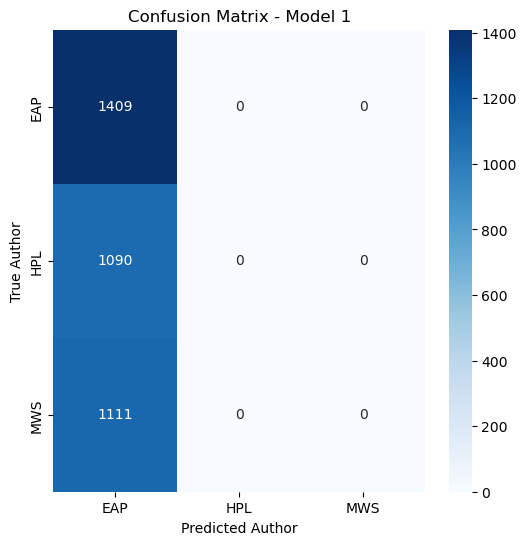

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.1523
Recall:    0.3903
F1-score:  0.2191


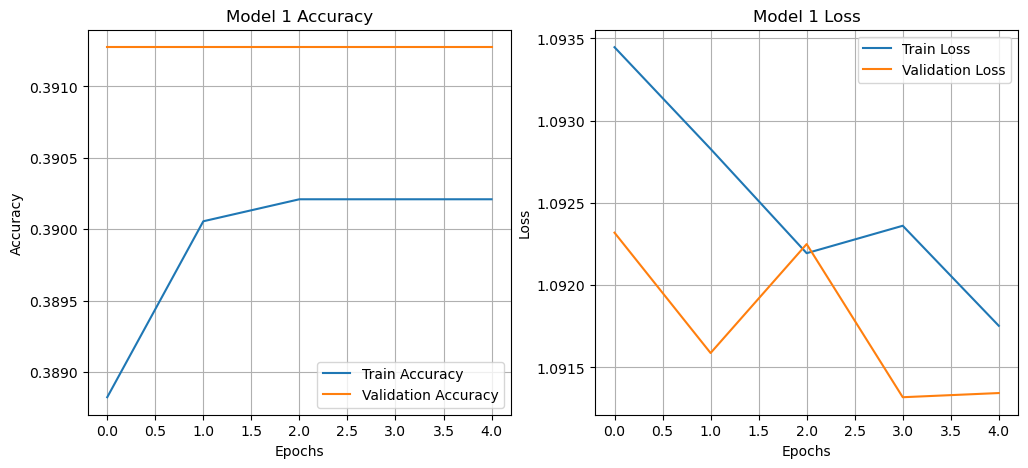

In [ ]:
# Model 1 Evaluation

#  Classification Report
print("Classification Report - Model 1:\n")
print(classification_report(y_test, predicted_classes, target_names=label_encoder.classes_))

#  Confusion Matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Author')
plt.ylabel('True Author')
plt.title('Confusion Matrix - Model 1')
plt.show()

# Calculate precision, recall, and F1-score of the model
precision = precision_score(y_test, predicted_classes, average='weighted')
recall = recall_score(y_test, predicted_classes, average='weighted')
f1 = f1_score(y_test, predicted_classes, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

# Plot Accuracy and Loss Curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model 1 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()





The model presents a **test loss of 1.0915** and a **test accuracy of 39%**. The high test loss suggests that the model struggled to correctly classify many of the test samples, indicating **underfitting** or insufficient learning. The relatively low accuracy is also notable, as with only three authors, even a random classifier could achieve comparable results. These findings indicate that the configuration used to build, compile, and train the model was not sufficient for effectively identifying authors based on their writing style.

The **classification report** provides further insights:  

- **Precision:** 0.1523 (15%) – measures the proportion of correctly predicted instances for each author among all instances predicted as that author.  
- **Recall:** 0.3903 (39%) – indicates how effectively the model identified all actual instances of each author.  
- **F1-score:** 0.2191 (21%) – combines both precision and recall to provide a balanced assessment of performance.  

The **confusion matrix** shows that the model predicted only a single class (**EAP**) for all samples. This highlights that the model is underfitting and failing to distinguish between the different authors. As a result, there are no correct classifications for **H.P. Lovecraft (HPL)** and **Mary Shelley (MWS)**.

The **accuracy and loss curves** illustrate the model’s learning behavior. Training accuracy gradually increases but remains relatively low, while validation accuracy stays higher throughout. Training loss initially decreases but then fluctuates, and validation loss shows a similar pattern. In general, training loss indicates how well the model is learning, while validation loss reflects its ability to generalize to new data (Frederik, 2023). Ideally, loss should decrease steadily and accuracy should increase, suggesting effective learning without overfitting. The observed fluctuations and low training accuracy indicate that the model is still struggling to learn the patterns in the data, and its performance needs improvement.

## Retrain the Model

The first model showed limited performance, with low accuracy and high loss, indicating underfitting and insufficient learning. To address these issues, we now retrain the model with an improved configuration.

In this section, we perform the following steps:

- Prepare hyperparameters for the model  
- Build the model using a **Sequential** architecture, including:  
  - Embedding layer  
  - **Bidirectional LSTM layer** to capture context from both forward and backward sequences  
  - Dense layer  
  - Dropout layer  
  - Output Dense layer  
- Add callbacks to improve training:  
  - **EarlyStopping** to halt training when validation loss stops improving  
  - **ReduceLROnPlateau** to dynamically adjust the learning rate  
- Compile and train the model on the training data

In [ ]:

# Hyperparameters

maxlen = 314 # Max sequence length
num_words = 15000 # Vocabulary size
embedding_dim = 200 # Embedding dimension
lstm_units = 256  # LSTM units
dense_units = 128 # Dense units
dropout_rate = 0.4# Dropout rate
recurrent_dropout = 0.3    # Recurrent dropout
learning_rate = 0.001  # Learning rate
batch_size = 64 # Batch size
epochs = 20 # Epochs

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

# Compute Class Weights
classes = np.unique(y_train)  # y_train is the encoded labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weights_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weights_dict)

# Build Model 2
model2 = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen),
    Bidirectional(LSTM(lstm_units, recurrent_dropout=recurrent_dropout)),
    Dense(dense_units, activation='relu'),
    Dropout(dropout_rate),
    Dense(len(label_encoder.classes_), activation='softmax')  # output layer
])

# Compile
model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

model2.summary()

# Train Model 2
history2 = model2.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
    class_weight=class_weights_dict  # Apply class weights
)

Class weights: {np.int64(0): np.float64(0.8540076900325347), np.int64(1): np.float64(1.103493082626309), np.int64(2): np.float64(1.0836148014711402)}


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1913s 9s/step - accuracy: 0.6189 - loss: 0.7974 - val_accuracy: 0.7825 - val_loss: 0.5494 - learning_rate: 0.0010
Epoch 2/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1839s 9s/step - accuracy: 0.8612 - loss: 0.3591 - val_accuracy: 0.8033 - val_loss: 0.4936 - learning_rate: 0.0010
Epoch 3/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1883s 9s/step - accuracy: 0.9224 - loss: 0.2079 - val_accuracy: 0.8006 - val_loss: 0.5608 - learning_rate: 0.0010
Epoch 4/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9555 - loss: 0.1263
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
204/204 ━━━━━━━━━━━━━━━━━━━━ 1885s 9s/step - accuracy: 0.9467 - loss: 0.1466 - val_accuracy: 0.7722 - val_loss: 0.7094 - learning_rate: 0.0010


## Evaluate the retrained Model  

In this section, we evaluate the retrained model’s performance using the following metrics and techniques:  

- **Loss**  
- **Accuracy**  
- **Classification report** (Precision, Recall, F1-score)  
- **Confusion matrix**  
- **Plots of training and validation loss and accuracy curves**  

In [40]:
# Evaluate the model
loss_2, accuracy_2 = model2.evaluate(X_test, y_test, verbose=0) 
print(f"Test Loss: {loss_2:.4f}, Test Accuracy: {accuracy_2:.4f}")

Test Loss: 0.5172, Test Accuracy: 0.7895


In [38]:
# make predictions
predictions_2 = model2.predict(X_test)
predicted_classes_2 = np.argmax(predictions_2, axis=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 80s 705ms/step


Classification Report - Model 2:

              precision    recall  f1-score   support

         EAP       0.77      0.81      0.78      1409
         HPL       0.83      0.74      0.79      1090
         MWS       0.79      0.81      0.80      1111

    accuracy                           0.79      3610
   macro avg       0.79      0.79      0.79      3610
weighted avg       0.79      0.79      0.79      3610



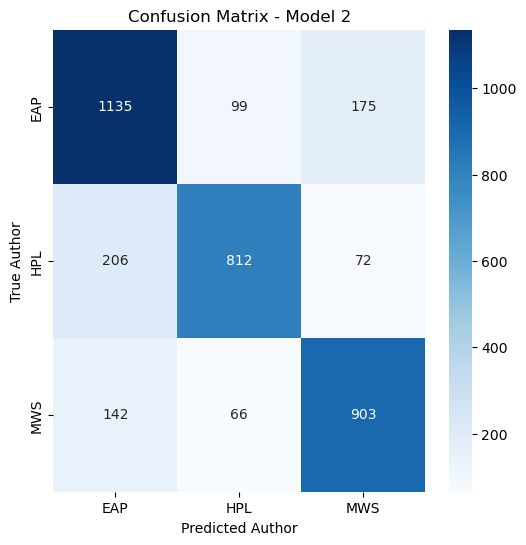

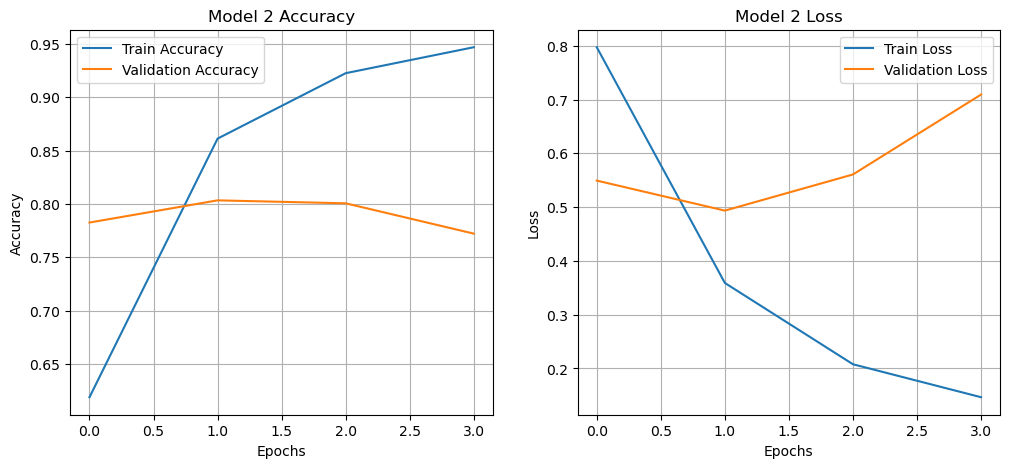

Precision: 0.7913
Recall:    0.7895
F1-score:  0.7894


In [53]:
# Model 2 Evaluation

#  Classification Report
print("Classification Report - Model 2:\n")
print(classification_report(y_test, predicted_classes_2, target_names=label_encoder.classes_))

#  Confusion Matrix
conf_matrix_2 = confusion_matrix(y_test, predicted_classes_2)

plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Author')
plt.ylabel('True Author')
plt.title('Confusion Matrix - Model 2')
plt.show()

# Plot Accuracy and Loss Curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model 2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

# Calculate precision, recall, and F1-score of the model
precision_2 = precision_score(y_test, predicted_classes_2, average='weighted')
recall_2 = recall_score(y_test, predicted_classes_2, average='weighted')
f1_2 = f1_score(y_test, predicted_classes_2, average='weighted')
print(f"Precision: {precision_2:.4f}")
print(f"Recall:    {recall_2:.4f}")
print(f"F1-score:  {f1_2:.4f}")

## Evaluate the Retrained Model

This model showed significant improvement, achieving a **test loss of 0.5172** and a **test accuracy of 78%**.  
The lower test loss indicates that the error between predicted and actual values has decreased, reflecting improved learning and generalization. At the same time, the higher accuracy demonstrates that the model is making more correct predictions, showing better performance compared to the first version.

The **classification report** provides further insights:  

- **Precision:** 0.7913 (79%) – measures the proportion of correctly predicted instances for each author among all instances predicted as that author.  
- **Recall:** 0.7895 (78%) – indicates how effectively the model identified all actual instances of each author.  
- **F1-score:** 0.7894 (78%) – combines both precision and recall to provide a balanced assessment of performance.  

The **confusion matrix** confirms that the model was able to correctly classify many instances for each author, but some misclassifications remain. For example:  

- **EAP:** 1,135 correctly predicted, while 89 were misclassified as HPL and 175 as MWS.  
- **HPL:** 812 correctly predicted, with 206 misclassified as EAP and 72 as MWS.  
- **MWS:** 903 correctly predicted, while 142 were misclassified as EAP and 66 as HPL.  

Compared to the previous version, this model shows clear improvements in the evaluation graphs. The **training loss** reflects how well the model is learning, while the **validation loss** shows its ability to generalize to new data (Frederik, 2023). We observed that the loss decreased steadily and accuracy increased, suggesting effective learning with minimal signs of overfitting.

## Conclusion

We have reached the end of this analysis, where the goal was to build a model capable of distinguishing or predicting an author based on their unique writing style. Using a dataset for author identification from Kaggle, we performed data cleaning and exploratory analysis, which provided a solid foundation to build an LSTM model from scratch.  

The **first model** achieved a test accuracy of **39%** with a loss of **1.0915**, indicating that it was not able to correctly predict the authors. To address these limitations, we tuned the hyperparameters and added a **Bidirectional LSTM layer**, enabling the model to capture context from both forward and backward sequences.  

After retraining, the **second model** achieved a significantly improved accuracy of **79%** with a reduced loss of **0.5127**, demonstrating a clear enhancement in performance. Despite this improvement, some misclassifications remained, as highlighted in the confusion matrix (Figure 22).  

There is still room for further refinement, and future work could include implementing **pre-trained embeddings such as GloVe**, which may further increase the model’s accuracy and overall performance.

## References  

- Abbasi, A. and Chen, H., 2005. Applying authorship analysis to extremist-group web forum messages. *IEEE Intelligent Systems*, 20(5), pp.67-75.  

- Adrian, G., 2018. A review of Dropout as applied to RNNs. [Online]. Available at: [https://adriangcoder.medium.com/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b](https://adriangcoder.medium.com/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b) (Accessed: 01 October 2025).  

- Aniruddha, B., 2025. Confusion Matrix in Machine Learning. [Online]. Available at: [https://www.analyticsvidhya.com/blog/2020/04/confusion-matrix-machine-learning/](https://www.analyticsvidhya.com/blog/2020/04/confusion-matrix-machine-learning/) (Accessed: 01 October 2025).  

- AWS. [s.a.]. What is RNN (Recurrent Neural Network)? [Online]. Available at: [https://aws.amazon.com/what-is/recurrent-neural-network/](https://aws.amazon.com/what-is/recurrent-neural-network/) (Accessed: 01 October 2025).  

- BTB. [s.a.]. Performance Insights: Train Loss vs. Test Loss in Machine Learning Models. [Online]. Available at: [https://baotramduong.medium.com/machine-learning-train-loss-vs-test-loss-735ccd713291](https://baotramduong.medium.com/machine-learning-train-loss-vs-test-loss-735ccd713291) (Accessed: 01 October 2025).  

- Databricks. [s.a.]. Keras Model. [Online]. Available at: [https://www.databricks.com/glossary/keras-model](https://www.databricks.com/glossary/keras-model) (Accessed: 01 October 2025).  

- GeeksforGeeks, 2025. Bidirectional LSTM in NLP. [Online]. Available at: [https://www.geeksforgeeks.org/nlp/bidirectional-lstm-in-nlp/](https://www.geeksforgeeks.org/nlp/bidirectional-lstm-in-nlp/) (Accessed: 01 October 2025).  

- Google Cloud. [s.a.]. What is deep learning? [Online]. Available at: [https://cloud.google.com/discover/what-is-deep-learning/](https://cloud.google.com/discover/what-is-deep-learning/) (Accessed: 01 October 2025).  

- Himanshu, S., 2018. Is your epochs not performing? Try callbacks. [Online]. Available at: [https://medium.com/@himanshuit3036/is-your-epochs-not-performing-try-callbacks-76519f0368a9](https://medium.com/@himanshuit3036/is-your-epochs-not-performing-try-callbacks-76519f0368a9) (Accessed: 01 October 2025).  

- Manik, S., 2020. Understanding Word Embeddings from Scratch | LSTM model. [Online]. Available at: [https://medium.com/data-science/word-embeddings-and-the-chamber-of-secrets-lstm-gru-tf-keras-de3f5c21bf16/](https://medium.com/data-science/word-embeddings-and-the-chamber-of-secrets-lstm-gru-tf-keras-de3f5c21bf16/) (Accessed: 01 October 2025).  

- Savoy, J., 2020. *Machine learning methods for stylometry: Authorship attribution and author profiling*. Cham: Springer International Publishing. [Online].  